<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4: Classification with Yelp, SGD, OOP

## Yelp

---

In this project you will be investigating a small version of the [Yelp challenge dataset](https://www.yelp.com/dataset_challenge). You'll practice using classification algorithms, cross-validation, gridsearching – all that good stuff.

---

### The data

There are 5 individual .csv files that have the information, zipped into .7z format like with the SF data last project. The dataset is located in your datasets folder:

    DSI-SF-2/datasets/yelp_arizona_data.7z

The columns in each are:

    businesses_small_parsed.csv
        business_id: unique business identifier
        name: name of the business
        review_count: number of reviews per business
        city: city business resides in
        stars: average rating
        categories: categories the business falls into (can be one or multiple)
        latitude
        longitude
        neighborhoods: neighborhoods business belongs to
        variable: "property" of the business (a tag)
        value: True/False for the property
        
    reviews_small_nlp_parsed.csv
        user_id: unique user identifier
        review_id: unique review identifier
        votes.cool: how many thought the review was "cool"
        business_id: unique business id the review is for
        votes.funny: how many thought the review was funny
        stars: rating given
        date: date of review
        votes.useful: how many thought the review was useful
        ... 100 columns of counts of most common 2 word phrases that appear in reviews in this review
        
    users_small_parsed.csv
        yelping_since: signup date
        compliments.plain: # of compliments "plain"
        review_count: # of reviews:
        compliments.cute: total # of compliments "cute"
        compliments.writer: # of compliments "writer"
        compliments.note: # of compliments "note" (not sure what this is)
        compliments.hot: # of compliments "hot" (?)
        compliments.cool: # of compliments "cool"
        compliments.profile: # of compliments "profile"
        average_stars: average rating
        compliments.more: # of compliments "more"
        elite: years considered "elite"
        name: user's name
        user_id: unique user id
        votes.cool: # of votes "cool"
        compliments.list: # of compliments "list"
        votes.funny: # of compliments "funny"
        compliments.photos: # of compliments "photos"
        compliments.funny: # of compliments "funny"
        votes.useful: # of votes "useful"
       
    checkins_small_parsed.csv
        business_id: unique business identifier
        variable: day-time identifier of checkins (0-0 is Sunday 0:00 - 1:00am,  for example)
        value: # of checkins at that time
    
    tips_small_nlp_parsed.csv
        user_id: unique user identifier
        business_id: unique business identifier
        likes: likes that the tip has
        date: date of tip
        ... 100 columns of counts of most common 2 word phrases that appear in tips in this tip

The reviews and tips datasets in particular have parsed "NLP" columns with counts of 2-word phrases in that review or tip (a "tip", it seems, is some kind of smaller review).

The user dataset has a lot of columns of counts of different compliments and votes. I'm not sure whether the compliments or votes are _by_ the user or _for_ the user.

---

If you look at the website, or the full data, you'll see I have removed pieces of the data and cut it down quite a bit. This is to simplify it for this project. Specifically, business are limited to be in these cities:

    Phoenix
    Surprise
    Las Vegas
    Waterloo

Apparently there is a city called "Surprise" in Arizona. 

Businesses are also restricted to at least be in one of the following categories, because I thought the mix of them was funny:

    Airports
    Breakfast & Brunch
    Bubble Tea
    Burgers
    Bars
    Bakeries
    Breweries
    Cafes
    Candy Stores
    Comedy Clubs
    Courthouses
    Dance Clubs
    Fast Food
    Museums
    Tattoo
    Vape Shops
    Yoga
    
---

### Project requirements

**You will be performing 4 different sections of analysis, like in the last project.**

Remember that classification targets are categorical and regression targets are continuous variables.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.grid_search import GridSearchCV

import statsmodels.formula.api as sm


#iowa = pd.merge(left=iowa, right=df, left_on=column name, right_on=right column name)

In [5]:
business_file = '../../datasets/yelp_arizona_data/businesses_small_parsed.csv'
business = pd.read_csv(business_file)

In [6]:
checkin_file = '../../datasets/yelp_arizona_data/checkins_small_parsed.csv'
checkin = pd.read_csv(checkin_file)

In [7]:
review_file = '../../datasets/yelp_arizona_data/reviews_small_nlp_parsed.csv'
review = pd.read_csv(review_file)

In [8]:
tip_file = '../../datasets/yelp_arizona_data/tips_small_nlp_parsed.csv'
tip = pd.read_csv(tip_file)

In [142]:
user_file = '../../datasets/yelp_arizona_data/users_small_parsed.csv'
user = pd.read_csv(user_file)

In [312]:
busi_cate = ['Airports','Breakfast & Brunch','Bubble Tea',
            'Burgers','Bars','Bakeries',
            'Breweries','Cafes','Candy Stores',
            'Comedy Clubs','Courthouses','Dance Clubs',
            'Fast Food','Museums','Tattoo',
            'Vape Shops','Yoga']

lasvegas = business[business['city'] == 'Las Vegas']
other_cities = business[business['city'] != 'Las Vegas']

In [412]:
the_weekend = ['18-5','19-5','20-5','21-5','22-5','23-5',#Friday from 6PM, all day Sat and till 10pm Sun
'0-6','1-6','2-6','3-6','4-6','5-6','6-6','7-6','8-6','9-6','10-6','11-6','12-6','13-6','14-6','15-6','16-6','17-6','18-6','19-6','20-6','21-6','22-6','23-6',
'0-0','1-0','2-0','3-0','4-0','5-0','6-0','7-0','8-0','9-0','10-0','11-0','12-0','13-0','14-0','15-0','16-0','17-0','18-0','19-0','20-0','21-0']

checkin['time_day'] = checkin['variable'].apply(lambda x: x[13:17])
checkin['day_of_week'] = checkin['time_day'].apply(lambda x: x[-1])
checkin['hour'] = checkin['time_day'].apply(lambda x: x[0:len(x)-2])
checkin['weekend'] = checkin['time_day'].apply(lambda x: x in the_weekend[0:53])
checkin['weekend_review'] = checkin[['value']].sum(axis=1).where(checkin['weekend'] == True)
checkin['weekday_review'] = checkin[['value']].sum(axis=1).where(checkin['weekend'] == False)
checkin['weekend_review'] = checkin['weekend_review'].fillna(0)
checkin['weekday_review'] = checkin['weekday_review'].fillna(0)

In [143]:
import json
user['compliments.plain'] = user['compliments.plain'].fillna(0)
user['compliments.cute'] = user['compliments.cute'].fillna(0)
user['compliments.writer'] = user['compliments.writer'].fillna(0)
user['compliments.note'] = user['compliments.note'].fillna(0)
user['compliments.hot'] = user['compliments.hot'].fillna(0)
user['compliments.cool'] = user['compliments.cool'].fillna(0)
user['compliments.profile'] = user['compliments.profile'].fillna(0)
user['compliments.list'] = user['compliments.list'].fillna(0)
user['compliments.photos'] = user['compliments.photos'].fillna(0)
user['compliments.funny'] = user['compliments.funny'].fillna(0)
user['compliments.more'] = user['compliments.more'].fillna(0)
user['help_score'] = user['votes.useful'] / user['review_count']
user['log_help_score'] = user['help_score'].apply(lambda x: np.log10(x))
user['yrs_elite'] = user['elite'].apply(lambda x: len(json.loads(x)))
del user['elite']

In [315]:
cat_list = business.categories.apply(lambda x: x.replace('[', '').replace(']', '').replace(" ", '').rstrip("'").split(','))
#set([item.replace(' " ', '') for cats in cat_list.values for item in cats])

business_cat_list = business.categories.apply(lambda x: x.replace('[', '').replace(']', '').replace(" ", '').rstrip("'").split(','))
#set([item.replace(' " ', '') for cats in cat_list.values for item in cats])
#business['catagories'] = business_cat_list
cd = business['categories'].apply(lambda x: pd.Series(x.split(',')))

rows_num = len(cd)
for i in range(rows_num):
    for j in range(9):
        if cd.ix[i][j] == False:
            pass
        else:    
            cd.ix[i][j] = str(cd.ix[i][j]).replace("]",'').replace("'", '').replace('[', '')


In [316]:
busi_cate = [' Airports',' Breakfast & Brunch',' Bubble Tea',
            ' Burgers',' Bars',' Bakeries',
            ' Breweries',' Cafes',' Candy Stores',
            ' Comedy Clubs',' Courthouses',' Dance Clubs',
            ' Fast Food',' Museums',' Tattoo',
            ' Vape Shops',' Yoga', 'Airports','Breakfast & Brunch','Bubble Tea',
            'Burgers','Bars','Bakeries',
            'Breweries','Cafes','Candy Stores',
            'Comedy Clubs','Courthouses','Dance Clubs',
            'Fast Food','Museums','Tattoo',
            'Vape Shops','Yoga']

cd[11] = cd[0].apply(lambda x: x if x in busi_cate else False)
cd[12] = cd[1].apply(lambda x: x if x in busi_cate else False)
cd[13] = cd[2].apply(lambda x: x if x in busi_cate else False)
cd[14] = cd[3].apply(lambda x: x if x in busi_cate else False)
cd[15] = cd[4].apply(lambda x: x if x in busi_cate else False)
cd[16] = cd[5].apply(lambda x: x if x in busi_cate else False)
cd[17] = cd[6].apply(lambda x: x if x in busi_cate else False)
cd[18] = cd[7].apply(lambda x: x if x in busi_cate else False)

In [317]:
zp = zip(cd[11], cd[12], cd[13], cd[14], cd[15], cd[16], cd[17], cd[18])

In [318]:
fin_cat = []
for i in zp:
    for z in range(8):
        if i[z]: 
            fin_cat.append(i[z])
finish_cat = pd.DataFrame(fin_cat)

 Dance Clubs
Bars
 Dance Clubs
Cafes
Fast Food
Bars
Breakfast & Brunch
 Bars
Bars
Breakfast & Brunch
 Dance Clubs
 Burgers
Burgers
 Fast Food
Cafes
 Fast Food
 Bars
Bars
Bars
Fast Food
Bars
 Dance Clubs
Burgers
 Fast Food
 Bars
Bars
 Dance Clubs
Bakeries
Fast Food
Bars
 Fast Food
Burgers
Fast Food
Bars
Fast Food
Bars
Bars
 Burgers
Fast Food
Breakfast & Brunch
 Bars
Breakfast & Brunch
Burgers
 Fast Food
Bars
 Bars
Fast Food
 Fast Food
 Bars
 Breweries
Bars
Burgers
 Fast Food
Burgers
 Fast Food
Fast Food
Bars
 Bars
Bars
 Breakfast & Brunch
Bars
Breakfast & Brunch
Bars
 Bars
Bars
 Burgers
Burgers
 Fast Food
Fast Food
 Breakfast & Brunch
Bars
Bars
 Breakfast & Brunch
Bakeries
 Bars
 Bars
Bars
Bars
Fast Food
Breakfast & Brunch
Fast Food
Breakfast & Brunch
Fast Food
Fast Food
Bars
Bars
 Bars
Bars
 Fast Food
Breakfast & Brunch
 Bars
Fast Food
Burgers
 Fast Food
 Bakeries
Bars
 Breakfast & Brunch
Burgers
 Bars
Breakfast & Brunch
 Bars
Fast Food
Burgers
Bars
 Burgers
Fast Food
Burgers
 Breakfas

In [319]:
finish_cat = pd.DataFrame(fin_cat)
finish_cat[0] = finish_cat[0].apply(lambda x: x.replace(' ',''))
business['final_categories'] = finish_cat[0]

In [321]:
#business = pd.merge(left=business, right=checkin, left_on=column name, right_on=right column name)
checkin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214299 entries, 0 to 214298
Data columns (total 7 columns):
business_id    214299 non-null object
variable       214299 non-null object
value          214299 non-null float64
time_day       214299 non-null object
day_of_week    214299 non-null object
hour           214299 non-null object
weekend        214299 non-null bool
dtypes: bool(1), float64(1), object(5)
memory usage: 10.0+ MB


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Constructing a "profile" for Las Vegas

---

Yelp is interested in building out what they are calling "profiles" for cities. They want you to start with just Las Vegas to see what a prototype of this would look like. Essentially, they want to know what makes Las Vegas distinct from the other four.

Use the data you have to predict Las Vegas from the other variables you have. You should not be predicting the city from any kind of location data or other data perfectly associated with that city (or another city).

You may use any classification algorithm you deem appropriate, or even multiple models. You should:

1. Build at least one model predicting Las Vegas vs. the other cities.
- Validate your model(s).
- Interpret and visualize, in some way, the results.
- Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

In [323]:
from sklearn.linear_model import LinearRegression
business['city'] = business['city'].map(lambda x: 1 if x == "Las Vegas" else 0)

y = business.city.values
X = business[['review_count']].values

linmod = LinearRegression()
linmod.fit(X, y)

print 'Intercept:', linmod.intercept_
print 'Coef(s):', linmod.coef_

Intercept: 0.593613558208
Coef(s): [ 0.00017865]


In [324]:
y_p1 = business[business.stars == 1].city.values
y_p2 = business[business.stars == 2].city.values
y_p3 = business[business.stars == 3].city.values
y_p4 = business[business.stars == 4].city.values
y_p5 = business[business.stars == 5].city.values
y_p1half = business[business.stars == 1.5].city.values
y_p2half = business[business.stars == 2.5].city.values
y_p3half = business[business.stars == 3.5].city.values
y_p4half = business[business.stars == 4.5].city.values

print 'P(city | stars = 1):', np.mean(y_p1)
print 'P(city | stars = 2):', np.mean(y_p2)
print 'P(city | stars = 3):', np.mean(y_p3)
print 'P(city | stars = 4):', np.mean(y_p4)
print 'P(city | stars = 5):', np.mean(y_p5)
print 'P(city | stars = 1.5):', np.mean(y_p1half)
print 'P(city | stars = 2.5):', np.mean(y_p2half)
print 'P(city | stars = 3.5):', np.mean(y_p3half)
print 'P(city | stars = 4.5):', np.mean(y_p4half)



P(city | stars = 1): 0.635294117647
P(city | stars = 2): 0.555048947298
P(city | stars = 3): 0.637113476981
P(city | stars = 4): 0.612813150339
P(city | stars = 5): 0.672022494477
P(city | stars = 1.5): 0.541412692721
P(city | stars = 2.5): 0.627896584743
P(city | stars = 3.5): 0.617734139737
P(city | stars = 4.5): 0.575675021189


In [325]:
def odds_ratio(p):
    return (float(p) / (1 - p))
print 'P(city | stars = 1):', odds_ratio(np.mean(y_p1))
print 'P(city | stars = 2):', odds_ratio(np.mean(y_p2))
print 'P(city | stars = 3):', odds_ratio(np.mean(y_p3))
print 'P(city | stars = 4):', odds_ratio(np.mean(y_p4))
print 'P(city | stars = 5):', odds_ratio(np.mean(y_p5))
print 'P(city | stars = 1.5):', odds_ratio(np.mean(y_p1half))
print 'P(city | stars = 2.5):', odds_ratio(np.mean(y_p2half))
print 'P(city | stars = 3.5):', odds_ratio(np.mean(y_p3half))
print 'P(city | stars = 4.5):', odds_ratio(np.mean(y_p4half))


P(city | stars = 1): 1.74193548387
P(city | stars = 2): 1.24743821579
P(city | stars = 3): 1.7556823871
P(city | stars = 4): 1.58273234454
P(city | stars = 5): 2.04898958971
P(city | stars = 1.5): 1.18060985145
P(city | stars = 2.5): 1.68742494424
P(city | stars = 3.5): 1.61598040514
P(city | stars = 4.5): 1.35668426309


In [326]:
def pred_to_odds(pred):
    return (pred / (1. + pred))

def minimize_gpa_odds(betas):
    pred = betas[0] + betas[1]*X.ravel()
    odds_pred = pred_to_odds(pred)
    return np.sum((y - odds_pred)**2)
from scipy.optimize import minimize

min_betas = minimize(minimize_gpa_odds, np.array([0.,1.]))
min_betas.x


array([ 1.39206151,  0.00227626])

In [327]:
y = business.city.values
X = business[['stars']].values

logreg = LogisticRegression()
logreg.fit(X, y)

print 'Logreg intercept:', logreg.intercept_
print 'Logreg coef(s):', logreg.coef_
print 'Logreg predicted probabilities:', logreg.predict_proba(X[0:5,:])

Logreg intercept: [ 0.4164039]
Logreg coef(s): [[ 0.01357607]]
Logreg predicted probabilities: [[ 0.38927896  0.61072104]
 [ 0.38766639  0.61233361]
 [ 0.38605627  0.61394373]
 [ 0.38444864  0.61555136]
 [ 0.38605627  0.61394373]]


In [328]:
xval_chance = (-1 * logreg.intercept_[0])/logreg.coef_[0][0]
print xval_chance*logreg.coef_[0][0] + logreg.intercept_
print xval_chance

logreg.predict_proba([[xval_chance]])

[ 0.]
-30.6719073187


array([[ 0.5,  0.5]])

In [329]:
Xc = X - X.mean()
print Xc[0:3, :]

logreg = LogisticRegression()
logreg.fit(Xc, y)

print 'Logreg intercept:', logreg.intercept_
print 'Logreg coef(s):', logreg.coef_

[[-0.97196595]
 [-0.47196595]
 [ 0.02803405]]
Logreg intercept: [ 0.46357125]
Logreg coef(s): [[ 0.01322096]]


In [330]:
def logistic_transformation(gpa, b0, b1):
    regression_sum = b0 + b1*gpa
    exponentiated = np.exp(regression_sum)
    return exponentiated / (1 + exponentiated)

In [331]:
print 'average stars:', np.mean(X[:,0])
print 'P(city | average stars = 3.509):', logistic_transformation(0, logreg.intercept_[0], logreg.coef_[0][0])

print 'stars = 2.5, difference from mean:', 3.5 - np.mean(X[:,0])
print 'P(city | stars = 3.5):', logistic_transformation(3.5 - np.mean(X[:,0]), 
                                                          logreg.intercept_[0], logreg.coef_[0][0])

average stars: 3.47196594954
P(city | average stars = 3.509): 0.613861033708
gpa = 2.5, difference from mean: 0.0280340504606
P(city | stars = 3.5): 0.613948884222


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Different categories of ratings

---

Yelp is finally ready to admit that their rating system sucks. No one cares about the ratings, they just use the site to find out what's nearby. The ratings are simply too unreliable for people. 

Yelp hypothesizes that this is, in fact, because different people tend to give their ratings based on different things. They believe that perhaps some people always base their ratings on quality of food, others on service, and perhaps other categories as well. 

1. Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
2. Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
3. Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice). 
4. Validate the performance of the models.
5. Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

In [3]:
tip_file = '../../datasets/yelp_arizona_data/tips_small_nlp_parsed.csv'
tip = pd.read_csv(tip_file)


In [9]:
tip = tip.merge(business, on='business_id', how='left')

In [10]:
del tip['city']
del tip['categories']
del tip['latitude']
del tip['longitude']
del tip['neighborhoods']
del tip['variable']
del tip['value']

In [11]:
tip['good_rating'] = np.where(tip['stars']>3.5, 1, 0)
tip.head()

,user_id,business_id,likes,date,24 hours,amazing food,animal style,awesome food,awesome place,awesome service,...,staff great,steak eggs,super friendly,sweet potato,velvet pancakes,worth wait,name,review_count,stars,good_rating
0,trdsekNRD-gIs50EBrScwA,EmzaQR5hQlF0WIl24NxAZA,0,2012-02-27,0,0,0,0,0,0,...,0,0,0,0,0,0,Sky Lounge,25,2.5,0
1,trdsekNRD-gIs50EBrScwA,EmzaQR5hQlF0WIl24NxAZA,0,2012-02-27,0,0,0,0,0,0,...,0,0,0,0,0,0,Sky Lounge,25,2.5,0
2,trdsekNRD-gIs50EBrScwA,EmzaQR5hQlF0WIl24NxAZA,0,2012-02-27,0,0,0,0,0,0,...,0,0,0,0,0,0,Sky Lounge,25,2.5,0
3,trdsekNRD-gIs50EBrScwA,EmzaQR5hQlF0WIl24NxAZA,0,2012-02-27,0,0,0,0,0,0,...,0,0,0,0,0,0,Sky Lounge,25,2.5,0
4,trdsekNRD-gIs50EBrScwA,EmzaQR5hQlF0WIl24NxAZA,0,2012-02-27,0,0,0,0,0,0,...,0,0,0,0,0,0,Sky Lounge,25,2.5,0


In [14]:
def df_subsetter(df, suffix):
    column_select = [x for x in tip.columns if suffix in x]
    tip_subset = tip[['business_id','likes','good_rating'] + column_select]
    tip_subset.columns = [x.replace(suffix, '') for x in tip_subset.columns]
    return tip_subset

tip_food = df_subsetter(tip, 'service')
tip_service = df_subsetter(tip, 'food')

In [45]:
tip_food['rating'] = tip_food.mean(axis=1)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [50]:
lm = LinearRegression() 

target = 'good_rating'
y = tip_food[target]
X = tip_food[['likes']]

In [38]:
model = lm.fit(X, y)

predictions = lm.predict(X)
predictions.shape

(4829248,)

In [41]:
score_r2 = model.score(X, y)
score_r2

2.7732478778741406e-05

In [42]:
model.coef_

array([ 0.01936652])

In [43]:
lm.intercept_

0.5348984332593637

In [52]:
from sklearn.metrics import mean_squared_error
print "MSE:", mean_squared_error(y, predictions)

 MSE: 0.248754608267


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Identifying "elite" users

---

Yelp, though having their own formula for determining whether a user is elite or not, is interested in delving deeper into what differentiates an elite user from a normal user at a broader level.

Use a classification model to predict whether a user is elite or not. Note that users can be elite in some years and not in others.

1. What things predict well whether a user is elite or not?
- Validate the model.
- If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Validate the model and compare it to the one with the count variables.
- Think of a way to visually represent your results in a compelling way.
- Give a brief write-up of your findings.
#

In [149]:
user['elite'] = user['yrs_elite'].apply(lambda x: 1 if x >= 1 else 0)

In [144]:
def df_subsetter(df, suffix):
    column_select = [x for x in user.columns if suffix in x]
    user_subset = user[['user_id','name'] + column_select]
    user_subset.columns = [x.replace(suffix, '') for x in user_subset.columns]
    return user_subset

user_compliements = df_subsetter(user, 'compliments')
user_vote = df_subsetter(user, 'votes')

In [145]:
user_compliements['sum'] = user_compliements.sum(axis=1)
user_vote['sum'] = user_vote.sum(axis=1)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [146]:
user['total_comp'] = user_compliements['sum']
user['total_vote'] = user_vote['sum']


In [147]:
user['help_score'] = user['help_score'].fillna(0)
user['log_help_score'] = user['log_help_score'].fillna(0)
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144206 entries, 0 to 144205
Data columns (total 25 columns):
yelping_since          144206 non-null object
compliments.plain      144206 non-null float64
review_count           144206 non-null int64
compliments.cute       144206 non-null float64
compliments.writer     144206 non-null float64
fans                   144206 non-null int64
compliments.note       144206 non-null float64
compliments.hot        144206 non-null float64
compliments.cool       144206 non-null float64
compliments.profile    144206 non-null float64
average_stars          144206 non-null float64
compliments.more       144206 non-null float64
name                   144206 non-null object
user_id                144206 non-null object
votes.cool             144206 non-null int64
compliments.list       144206 non-null float64
votes.funny            144206 non-null int64
compliments.photos     144206 non-null float64
compliments.funny      144206 non-null float64
votes.u

In [158]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression() 

y = user['elite']

X = user[['total_comp', 'total_vote','review_count']]

print y.shape, X.shape

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
(144206,) (144206, 3)


In [159]:
model = lm.fit(X, y)

predictions = lm.predict(X)
predictions.shape

(144206,)

In [160]:
print user['elite'].mean()
print predictions.mean()
mean_squared_error(y, predictions)

0.115272596147
0.115272596147


0.064872913274953287

In [161]:
score_r2 = model.score(X, y)
print score_r2
print model.coef_

print lm.intercept_

0.363896408607
[  2.66522653e-05  -2.39379023e-05   1.51551836e-03]
0.0365223775019


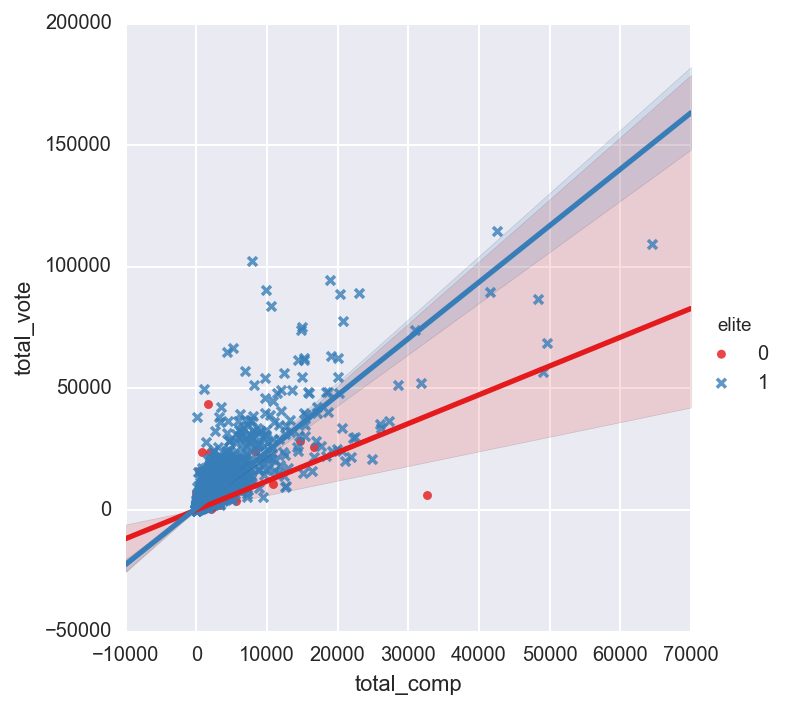

In [166]:
sns.lmplot(x="total_comp", y="total_vote", hue="elite", data=user,
           markers=["o", "x"], palette="Set1")

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Find something interesting on your own

---

You want to impress your superiors at Yelp by doing some investigation into the data on your own. You want to do classification, but you're not sure on what.

1. Create a hypothesis or hypotheses about the data based on whatever you are interested in, as long as it is predicting a category of some kind (classification).
2. Explore the data visually (ideally related to this hypothesis).
3. Build one or more classification models to predict your target variable. **Your modeling should include gridsearching to find optimal model parameters.**
4. Evaluate the performance of your model. Explain why your model may have chosen those specific parameters during the gridsearch process.
5. Write up what the model tells you. Does it validate or invalidate your hypothesis? Write this up as if for a non-technical audience.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. ROC and Precision-recall

---

Some categories have fewer overall businesses than others. Choose two categories of businesses to predict, one that makes your proportion of target classes as even as possible, and another that has very few businesses and thus makes the target varible imbalanced.

1. Create two classification models predicting these categories. Optimize the models and choose variables as you see fit.
- Make confusion matrices for your models. Describe the confusion matrices and explain what they tell you about your models' performance.
- Make ROC curves for both models. What do the ROC curves describe and what do they tell you about your model?
- Make Precision-Recall curves for the models. What do they describe? How do they compare to the ROC curves?
- Explain when Precision-Recall may be preferable to ROC. Is that the case in either of your models?

## OOP, Stochastic Gradient Descent, and Linear Algebra

---

In this part of the project, you will implement machine learning algorithms we have covered in class from scratch. 

--- 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 6. Extend the `LinearRegrssion` class to include the following: 

- Calculate confidence intervals at X% on the $\beta$ coefficients and predicted y value when the model is not regularized. Here is a good overview of calculating confidence intervals: http://imgur.com/a/O1ZFk



- An option to regularize the model with Ridge Regression. The method should automatically calculate the best `alpha` for the user. The closed form solution for Ridge Regression may be helpful [Hint: Think of the `n_alphas` parameter in sklearn]

Protip: Compare if your implemenation works by applying it on the Diabetes Dataset and seeing it how it compares to opensource implemenations in `sklearn` and `statsmodels`. 

http://statsmodels.sourceforge.net/devel/examples/#regression

http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 7. Extend the `NearestNeighbor` class such that the fit method doesn't use a `for loop`


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 8. Implement `LogisticRegression` that fits the model using Stochastic Gradient Descent. 

Check if the results of your `LogisticRegression` implementation matches with the Sklearn implementation: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">
### 9. Singular Value Decomposition 

- Read articles on image compression with SVD and use `numpy` apply it to images from the MNIST Datasets. To get the MNIST Datset, use the following comands. Note that the `mnist` data has shape `(70000, 784)`. You will need to convert it to 28x28 images [Hint: `np.reshape`]. 
       
       from sklearn.datasets import fetch_mldata
       mnist = fetch_mldata('MNIST original', data_home=custom_data_home)

    https://inst.eecs.berkeley.edu/~ee127a/book/login/l_svd_apps_image.html

    http://www.frankcleary.com/svdimage/
    
    
- Apply Logistic Regression to classify MNIST Images. This may require having the images be `784` dimensions rather than `28x28`. Compare results of the classifier on a test set when you apply it on the raw dataset vs. the compressed version of dataset from SVD. 

## Optional: Interview Practice

## Coding Questions 
- Implement Binary Search in Python and write down the algorithmic complexity of the Binary Search Algorithm.


- Implement Merge Sort in Python [Hint: First implement the `merge` function that combines two sorted arrays into one sorted array linear time]. What is the time complexity of `mergesort` ?


- Find the closest pair from two sorted arrays. Given two sorted arrays and a number x, find the pair whose sum is closest to x and the pair has an element from each array. We are given two arrays ar1[0…m-1] and ar2[0..n-1] and a number x, we need to find the pair ar1[i] + ar2[j] such that absolute value of (ar1[i] + ar2[j] – x) is minimum. What is the time complexity of this algorithm?

In [39]:
def merge_sort(a,b):
    merge_list = []
    while a or b:
        if a and b:
            if a[0] <= b[0]:
                merge_list.append(list[0])
                a = a[1:]
            else:
                merge_list.append(b[0])
                b = b[1:]
        elif a:
            merge_list.append(a[0])
            a = a[1:]
        elif b:
            merge_list.append(b[0])
            b =b[1:]
    return merge_list
    


In [ ]:
#
c = []
while a and b:
    if a[0] == b[0]:
        c.append(a.pop(0))
        b.pop(0)
    elif a[0] < b[0]:
        c.append(a.pop(0))
    else:
        c.append(b.pop(0))

if a:
    c.extend(a)
if b:
    c.extend(b)
c

## Probability  and Statistics Questions 

- In any 15-minute interval, there is a 20% probability that you will see at least one shooting star. What is the probability that you see at least one shooting star in the period of an hour?


- A certain couple tells you that they have two children, at least one of which is a girl. What is the probability that they have two girls?


# ANSWER

1) 1-(1-0.2)^4

2) 1/3

## Interview Questions Related to Material

- Explain what is bias-variance tradeoff to a non-technical person. Why is it a useful framework? How do you detect bias in your models? How about you variance? 


- Explain why cross-validation is important. 


- What is regularization? What are the advantages/disadvantages of different types of regularization schemes? 


- What are the loss functions associated with linear regression, logistic regression, and KNN? 


- Can you give examples of feature engineering on datasets you have worked with? 

# ANSWER
1) Bias is that if a robot takes an image, it may only capture certain photos of what you train it to be. So the bias is that you do not capture everything else that it is not trained. 

Bias is bility to predict an outcome based on the info provided. 
Variance is how unpredictable your outcome is.

2) Cross Validation is when you split up your data sets to train and test to get a sense of how your model is working